In this worksheet, the following are calculated:
1. Plot on map location of viable brackish water sites
2. Plot on map centroids of counties indicating the agriculture demand locations
3. % demand of a county that can be met by all the brackish wells within the county
4. % demand of agriculture in a county that can be met without exceeding a maximum LCOW


In [2]:
max_LCOW = 1.6  #$/m3
transport_cost = 0.115   #$/m3/km

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import haversine as hs
import geopandas as gp
from shapely.geometry import Point, Polygon
import numpy as np

from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock

Map brackish water sites that meet the following criteria
1. Well yield > 0.01
2. 0.5< TDS< 25 in kg/m3
3. Contiguous US states

LCOW calculated currently without transportation costs
File - brackish_sites_with_metrics

In [4]:
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics.csv')
ag_metric_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Agriculture/Clean/USGS_ag_metric.csv')

Updating the agriculture dataframe (copied from previous code) to extract relevant columns and correct the state and county names

In [5]:
# take total irrigation demand from ag_df
ag_df = ag_metric_df.loc[:, ['STATE', 'COUNTY', 'IR-WFrTo']].copy() # total irrigation withdrawals

# edit strings to improve matching between csv files
ag_df['COUNTY'] = ag_df['COUNTY'].str.replace('(\sCity|\sCounty|\sParish)$', '', regex=True)
ag_df['COUNTY'] = ag_df['COUNTY'].str.replace('St. ', 'Saint ', regex=False)
ag_df['COUNTY'] = ag_df['COUNTY'].str.replace('Ste. ', 'Sainte ', regex=False)
ag_df['COUNTY'] = ag_df['COUNTY'].str.replace('LaSalle', 'La Salle')

# clean up ag_df
# ag_df['county_state'] = ag_df['COUNTY'] + '_' + ag_df['STATE'] # create column combining county and state
# ag_df = ag_df[ag_df['county_state'].duplicated() == False] # delete county_state duplicates
# ag_df.set_index('COUNTY', inplace=True) # set county_state as the index

A sample map for Texas

In [6]:
texas = gp.read_file('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/GeoData/Texas Counties Map/geo_export_c05b3355-1638-4e46-b56c-ac18de751ed8.shp')
texas = texas.to_crs("EPSG:4326")
texas_centroid = gp.read_file('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/GeoData/Texas Counties Centroid Map/geo_export_d58b4a94-13f1-42f4-b03f-567c0e3ad095.shp')
texas_centroid = texas_centroid.to_crs("EPSG:4326")

In [7]:
bw_long = bw_df[bw_df['state_alpha']=='TX']['Longitude']
bw_lat = bw_df[bw_df['state_alpha']=='TX']['Latitude']

bw_geometry = [Point(xy) for xy in zip(bw_long,bw_lat)]
bw_geo_df = gp.GeoDataFrame(geometry = bw_geometry, crs='EPSG:4326')
bw_geo_df.geometry = bw_geo_df.geometry.to_crs('EPSG:4326')
bw_geo_df = bw_geo_df.assign(county_nm = bw_df[bw_df['state_alpha'] =='TX']['county_nm'].values)

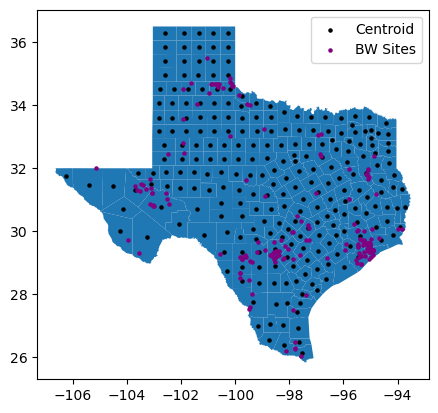

In [8]:
fig, ax = plt.subplots()
# states[states['NAME'] == 'Texas'].plot(ax=ax,figsize=(20, 20))
texas.plot(ax=ax,figsize=(50, 50),linewidth=0.5)
texas_centroid.plot(ax=ax, color = 'black', markersize = 5, label ='Centroid')
bw_geo_df.plot(ax=ax, color='purple', markersize = 5,label = "BW Sites")

ax.legend()

County level % Demand met
1. Assuming only brackish water sites within the county supply to the county
2. Adding transportation cost to LCOW based on the value in variable transport_cost
3. No limitation on maximum distance

Creating a dataframe for county level demand and distances between centroid and brackish water sites
Sorting in ordering of increasing distance


In [9]:
bw_state_df = bw_df[bw_df['state_alpha']=='TX']
bw_state_df = bw_state_df.set_index('unique_site_ID')

ag_state_df =  ag_df[ag_df['STATE']=='TX']
ag_state_df.set_index('COUNTY', inplace=True)

In [10]:
bw_state_df.loc

In [11]:
texas_centroid[texas_centroid['cnty_nm']== 'Willacy'].index.values

array([94], dtype=int64)

In [12]:
cols = ['County','CentroidLatitude','CentroidLongitude','CountyDemand','BWSites','BWLatitude','BWLongitude','BWAvailable','Distance_km',
        'AgDemandFracMet','LCOW','TransportOnM','tLCOW','WeightedtLCOW','Cum_AgDemandFracMet']

ag_bw_df = pd.DataFrame(columns=cols)

for county in ag_state_df.index:

    centroid_long = texas_centroid[texas_centroid['cnty_nm']== county]['y_long'].values[0]
    centroid_lat = texas_centroid[texas_centroid['cnty_nm']== county]['x_lat'].values[0]

    centroid_loc = (centroid_lat,centroid_long)
    
  
    for site in bw_state_df[bw_state_df['county_nm'] == county].index:
        bw_long = bw_state_df['Longitude'].loc[site]
        bw_lat = bw_state_df['Latitude'].loc[site]

        bw_loc = (bw_lat,bw_long)
        dist_km = hs.haversine(centroid_loc,bw_loc)
        
        bw_available = bw_state_df['well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
        ag_demand_frac_met = bw_available*3600*24*365/ag_state_df['IR-WFrTo'].loc[county] if ag_state_df['IR-WFrTo'].loc[county] !=0 else 0
        lcow = bw_state_df['lcow'].loc[site]
        transport_onm = transport_cost*dist_km*bw_available*365*24*3600
        tlcow = (lcow*bw_available*365*24*3600 + transport_onm)/(bw_available*365*24*3600) 
        
        temp_dict =  {'County' : county,
                      'CentroidLatitude' : centroid_lat,
                      'CentroidLongitude' : centroid_long,
                      'CountyDemand' : ag_state_df['IR-WFrTo'].loc[county],
                      'BWSites' : site,
                      'BWLatitude' : bw_lat,
                      'BWLongitude' : bw_long,
                      'BWAvailable' : bw_available,
                      'Distance_km' : dist_km,
                      'AgDemandFracMet' : ag_demand_frac_met,
                      'LCOW' : lcow,
                      'TransportOnM' : transport_onm,
                      'tLCOW' : tlcow,
                      'WeightedtLCOW': 0,
                      'Cum_AgDemandFracMet': 0}
        
        temp = pd.DataFrame(temp_dict,index= [0])    
        ag_bw_df = pd.concat([ag_bw_df,temp],ignore_index=True)
        ag_bw_df.reset_index()

ag_bw_df_sorted1 = ag_bw_df.sort_values(['County','tLCOW']).groupby('County')
ag_bw_df_sorted2 = ag_bw_df.sort_values(['County','Distance_km']).groupby('County')

ag_bw_df.head()    

,County,CentroidLatitude,CentroidLongitude,CountyDemand,BWSites,BWLatitude,BWLongitude,BWAvailable,Distance_km,AgDemandFracMet,LCOW,TransportOnM,tLCOW,WeightedtLCOW,Cum_AgDemandFracMet
0,Anderson,31.813215,-95.652518,8.428221e+05,NURE-OR21755,31.988000,-95.786000,0.019660,23.162626,0.735637,0.991262,1.651525e+06,3.654964,0,0
1,Andrews,32.305063,-102.637884,1.803087e+07,USGS-322805102283801,32.468155,-102.477661,0.020389,23.563194,0.035660,0.905409,1.742329e+06,3.615177,0,0
2,Angelina,31.254759,-94.611742,1.381676e+05,NURE-OR14308,31.184000,-94.788000,0.034098,18.515734,7.782707,0.849960,2.289684e+06,2.979269,0,0
3,Atascosa,28.894184,-98.527413,2.706702e+07,NURE-OR5103,29.032000,-98.546000,0.028929,15.430747,0.033705,0.867875,1.618918e+06,2.642411,0,0
4,Atascosa,28.894184,-98.527413,2.706702e+07,NURE-OR5106,29.127000,-98.576000,0.057950,26.315580,0.067517,0.690248,5.530538e+06,3.716540,0,0


In [15]:
ag_bw_df = ag_bw_df_sorted2.apply(pd.DataFrame).set_index('County')

In [16]:
weighted_lcow = []
cum_ag_demand_frac_met = []

for county in ag_bw_df.index.unique():
    cum_bw_available = np.array(ag_bw_df['BWAvailable'].loc[county].cumsum())
    cum_cost = np.array((ag_bw_df['BWAvailable'].loc[county]*ag_bw_df['tLCOW'].loc[county]).cumsum())

    temp = np.divide(cum_cost,cum_bw_available) 
    weighted_lcow = np.append(weighted_lcow, temp,axis=0)

    temp_demand_met = np.array(ag_bw_df['AgDemandFracMet'].loc[county].cumsum())
    # print(county,len(temp_demand_met))
    cum_ag_demand_frac_met = np.append(cum_ag_demand_frac_met,temp_demand_met,axis=0)

ag_bw_df['WeightedtLCOW'] = weighted_lcow
ag_bw_df['Cum_AgDemandFracMet'] = cum_ag_demand_frac_met
ag_bw_df.head()

,CentroidLatitude,CentroidLongitude,CountyDemand,BWSites,BWLatitude,BWLongitude,BWAvailable,Distance_km,AgDemandFracMet,LCOW,TransportOnM,tLCOW,WeightedtLCOW,Cum_AgDemandFracMet
County,,,,,,,,,,,,,,
Anderson,31.813215,-95.652518,8.428221e+05,NURE-OR21755,31.988000,-95.786000,0.019660,23.162626,0.735637,0.991262,1.651525e+06,3.654964,3.654964,0.735637
Andrews,32.305063,-102.637884,1.803087e+07,USGS-322805102283801,32.468155,-102.477661,0.020389,23.563194,0.035660,0.905409,1.742329e+06,3.615177,3.615177,0.035660
Angelina,31.254759,-94.611742,1.381676e+05,NURE-OR14308,31.184000,-94.788000,0.034098,18.515734,7.782707,0.849960,2.289684e+06,2.979269,2.979269,7.782707
Atascosa,28.894184,-98.527413,2.706702e+07,NURE-OR5103,29.032000,-98.546000,0.028929,15.430747,0.033705,0.867875,1.618918e+06,2.642411,2.642411,0.033705
Atascosa,28.894184,-98.527413,2.706702e+07,NURE-OR5106,29.127000,-98.576000,0.057950,26.315580,0.067517,0.690248,5.530538e+06,3.716540,3.358874,0.101223


In [17]:
ag_bw_df.loc['Atascosa']['WeightedtLCOW']

County
Atascosa    2.642411
Atascosa    3.358874
Name: WeightedtLCOW, dtype: float64

Map the maximum % demand that be potentially met with all brackish water sites

In [18]:
texas=texas.set_index('name')

Text(0.5, 1.0, '% Average tLCOW')

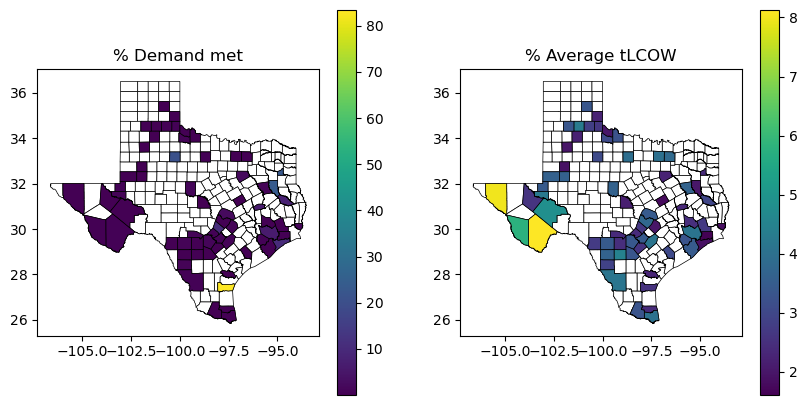

In [19]:
ag_demand_met_df = ag_bw_df.groupby('County').last()

fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,5))
texas.plot(ax=ax0, figsize=(50,50),color = 'white',edgecolor = "black",linewidth=0.5)
texas.loc[ag_bw_df.index.unique().values].plot(column = ag_demand_met_df['Cum_AgDemandFracMet'], ax=ax0,figsize=(50, 50),edgecolor = "black",linewidth=0.5 , legend=True)
ax0.set_title('% Demand met')

texas.plot(ax=ax1, figsize=(50,50),color = 'white',edgecolor = "black",linewidth=0.5)
texas.loc[ag_bw_df.index.unique().values].plot(column = ag_demand_met_df['WeightedtLCOW'], ax=ax1,figsize=(50, 50),edgecolor = "black",linewidth=0.5 , legend=True)
ax1.set_title('% Average tLCOW')

Map the maximum % demand that be potentially met with all brackish water sites
1. Assuming the tLCOW does not exceed maximum LCOW
2. Or 100% demand is met

TODO: In the cases where the adding an additional brackish water site excced maximum LCOW calculate additional fractional supply possible

Text(0.5, 1.0, '% Average tLCOW')

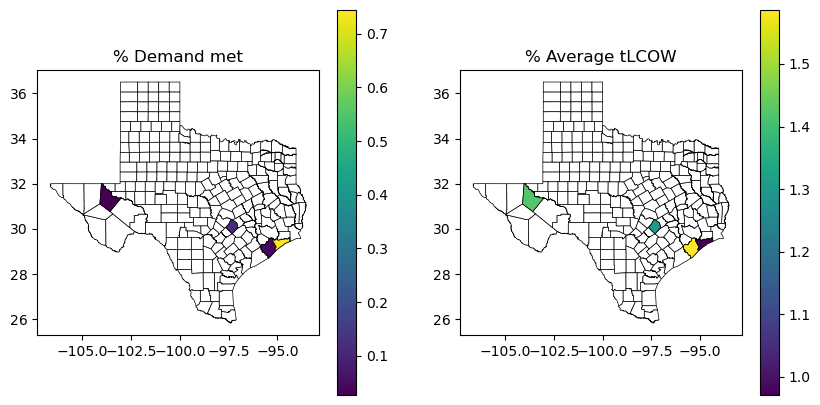

In [20]:
ag_demand_met_conditional_df = ag_bw_df[(ag_bw_df['Cum_AgDemandFracMet']<=1)& (ag_bw_df['WeightedtLCOW']<=max_LCOW)].groupby('County').last()

fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,5))
texas.plot(ax=ax0, figsize=(50,50),color = 'white',edgecolor = "black",linewidth=0.5)
texas.loc[ag_demand_met_conditional_df.index.unique().values].plot(column = ag_demand_met_conditional_df['Cum_AgDemandFracMet'], ax=ax0,figsize=(50, 50),edgecolor = "black",linewidth=0.5 , legend=True)
ax0.set_title('% Demand met')

texas.plot(ax=ax1, figsize=(50,50),color = 'white',edgecolor = "black",linewidth=0.5)
texas.loc[ag_demand_met_conditional_df.index.unique().values].plot(column = ag_demand_met_conditional_df['WeightedtLCOW'], ax=ax1,figsize=(50, 50),edgecolor = "black",linewidth=0.5 , legend=True)
ax1.set_title('% Average tLCOW')